In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.optim as optim

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. Define transformations (convert to tensor & normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 2. Download datasets
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
val_dataset   = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 3. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [3]:
def build_mlp(input_dim, hidden_dim, num_hidden_layers, activation_fn, output_dim=10):
    layers = []
    # Input layer
    layers.append(nn.Linear(input_dim, hidden_dim))
    layers.append(activation_fn())
    
    # Hidden layers
    for _ in range(num_hidden_layers - 1):
        layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(activation_fn())
    
    # Output layer
    layers.append(nn.Linear(hidden_dim, output_dim))
    return nn.Sequential(*layers)


In [4]:
def train_and_evaluate(model,train_loader,val_loader,optimizer_class,lr,num_epochs,device):
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    
    optimizer = optimizer_class(model.parameters(), lr=lr)
    train_losses,val_losses,val_accuracies = [],[],[] 
    
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = (X_batch.view(X_batch.size(0), -1).to(device), 
                                y_batch.to(device))
            optimizer.zero_grad()
            pred = model(X_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * X_batch.size(0)
        train_losses.append(epoch_train_loss / len(train_loader.dataset))
        
        model.eval()
        epoch_val_loss = 0
        correct = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.view(X_batch.size(0), -1).to(device),y_batch.to(device)
                preds = model(X_batch)
                loss = loss_fn(preds, y_batch)
                epoch_val_loss += loss.item() * X_batch.size(0)
                correct += (preds.argmax(dim=1) == y_batch).sum().item()
            val_losses.append(epoch_val_loss / len(val_loader.dataset))
            val_accuracies.append(correct / len(val_loader.dataset))
    return train_losses, val_losses, val_accuracies,model

In [5]:
def hyperparameter_tuning(train_loader, val_loader, device,learning_rates,optimizers,
                          hidden_layers,hidden_dims,num_epochs,activation_fn):
    best_model = None
    best_acc = 0
    best_params = None
    results = {}
    
    for lr in learning_rates:
        for opt_class in optimizers:
            for layers in hidden_layers:
                for h_dim in hidden_dims:
                    print(f"Training: LR={lr}, Optim={opt_class.__name__}, Layers={layers}, Hidden={h_dim}")
                    model = build_mlp(input_dim=28*28, hidden_dim=h_dim, num_hidden_layers=layers, activation_fn=activation_fn)
                    train_losses , val_losses,val_acc,trained_model = train_and_evaluate(model,train_loader,val_loader,opt_class,lr,num_epochs,device)
                    results[(lr,opt_class.__name__,layers,h_dim)] = {
                        'train_losses': train_losses,
                        'val_losses': val_losses,
                        'val_acc': val_acc
                    }
                    if val_acc[-1] > best_acc:
                        best_acc = val_acc[-1]
                        best_model = trained_model
                        best_params = (lr, opt_class.__name__, layers, h_dim)
                    
    print(f"\nBest validation accuracy: {best_acc:.4f} with params: {best_params}")
    return best_model, best_params, best_acc, results


In [6]:
import random

def random_hyperparameter_tuning(train_loader, val_loader, device,
                                 learning_rates, optimizers,
                                 hidden_layers, hidden_dims,
                                 num_epochs, activation_fn,
                                 num_trials=5):
    """
    Random search hyperparameter tuning for Fashion MNIST.
    
    Args:
        train_loader, val_loader: PyTorch DataLoaders
        device: 'cpu' or 'cuda'
        learning_rates: list of learning rates to sample
        optimizers: list of optimizer classes to sample
        hidden_layers: list of hidden layer counts to sample
        hidden_dims: list of hidden layer dimensions to sample
        num_epochs: number of epochs per trial
        activation_fn: activation function class (nn.ReLU, nn.Tanh, etc.)
        num_trials: number of random trials to perform
    Returns:
        best_model, best_params, best_acc, results
    """
    
    best_model = None
    best_acc = 0
    best_params = None
    results = {}
    
    for trial in range(num_trials):
        lr = random.choice(learning_rates)
        opt_class = random.choice(optimizers)
        layers = random.choice(hidden_layers)
        h_dim = random.choice(hidden_dims)
        
        print(f"Trial {trial+1}/{num_trials}: LR={lr}, Optim={opt_class.__name__}, Layers={layers}, Hidden={h_dim}")
        
        model = build_mlp(input_dim=28*28, hidden_dim=h_dim,
                          num_hidden_layers=layers, activation_fn=activation_fn)
        
        train_losses, val_losses, val_acc, trained_model = train_and_evaluate(
            model, train_loader, val_loader, opt_class, lr, num_epochs, device
        )
        
        results[(lr, opt_class.__name__, layers, h_dim)] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_acc': val_acc
        }
        
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            best_model = trained_model
            best_params = (lr, opt_class.__name__, layers, h_dim)
    
    print(f"\nBest validation accuracy: {best_acc:.4f} with params: {best_params}")
    return best_model, best_params, best_acc, results


In [7]:
import matplotlib.pyplot as plt

def plot_training_results(train_losses, val_losses, val_accuracies, title="Training Results"):
    plt.figure(figsize=(10,5))
    
    # Plot losses
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Val Loss', color='red')
    
    # Plot accuracy on secondary y-axis
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    ax2.plot(val_accuracies, label='Val Accuracy', color='green')
    
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax2.set_ylabel("Accuracy")
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


Training: LR=0.001, Optim=Adam, Layers=2, Hidden=512

Best validation accuracy: 0.8935 with params: (0.001, 'Adam', 2, 512)


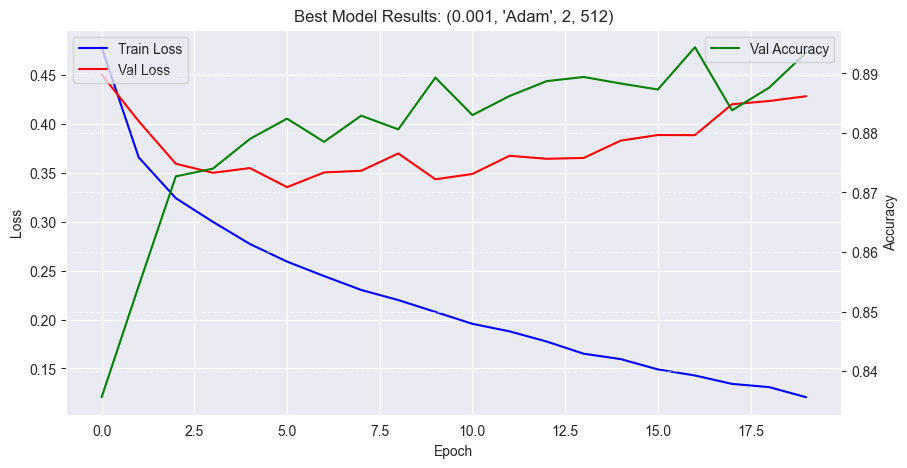

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rates = [1e-3]
optimizers = [torch.optim.Adam]
hidden_layers = [2]
hidden_dims = [512]
num_epochs = 50
activation_fn = nn.ReLU


best_model,best_params,best_acc,results = hyperparameter_tuning(
    train_loader,val_loader,device,learning_rates,optimizers,hidden_layers,hidden_dims,num_epochs,activation_fn
)

train_losses = results[best_params]['train_losses']
val_losses = results[best_params]['val_losses']
val_acc = results[best_params]['val_acc']

plot_training_results(train_losses, val_losses, val_acc,
                      title=f"Best Model Results: {best_params}")

---------------------
Another way to solve this task better



In [20]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(128, 10)
        

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x


In [21]:
import torch.nn as nn
import torch.optim as optim

def train_and_evaluate(model, train_loader, test_loader, device, 
                       num_epochs=30, learning_rate=1e-3):
    """
    Train and evaluate a PyTorch model on a dataset.
    
    Args:
        model: nn.Module - your neural network
        train_loader: DataLoader - training data
        test_loader: DataLoader - validation/test data
        device: torch.device - CPU or GPU
        num_epochs: int - number of training epochs
        learning_rate: float - optimizer learning rate
        
    Returns:
        metrics: dict with train_losses, test_losses, test_accuracies
    """
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()  # suitable for multi-class classification
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images = images.view(images.size(0), -1).to(device)  # flatten 28x28 → 784
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Evaluate on test set
        model.eval()
        correct = 0
        total = 0
        test_loss_total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.view(images.size(0), -1).to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss_total += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_test_loss = test_loss_total / len(test_loader)
        test_accuracy = 100 * correct / total
        
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)
        
        print(f"Epoch [{epoch}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} "
              f"Test Loss: {avg_test_loss:.4f} "
              f"Test Accuracy: {test_accuracy:.2f}%")
    
    metrics = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies
    }
    
    return model, metrics


In [22]:
import matplotlib.pyplot as plt

def plot_training_metrics(metrics):
    """
    Plots train loss, test loss, and test accuracy per epoch.
    
    Args:
        metrics: dict containing:
            'train_losses': list of training losses
            'test_losses': list of validation/test losses
            'test_accuracies': list of validation/test accuracies
    """
    train_losses = metrics['train_losses']
    test_losses = metrics['test_losses']
    test_accuracies = metrics['test_accuracies']
    epochs = range(1, len(train_losses) + 1)
    
    fig, ax1 = plt.subplots(figsize=(10,6))
    
    # Plot train and test loss
    ax1.plot(epochs, train_losses, 'b-o', label='Train Loss')
    ax1.plot(epochs, test_losses, 'r-o', label='Test Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Test Loss & Test Accuracy')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')
    
    # Plot accuracy on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(epochs, test_accuracies, 'g-s', label='Test Accuracy')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_ylim([0, 100])
    ax2.legend(loc='upper right')
    
    plt.show()


In [25]:
import torch
from torchvision import datasets, transforms

# 1️⃣ Define batch size
batch_size = 64

# 2️⃣ Download and prepare datasets
train_data = datasets.MNIST(
    root='./data',
    train=True,
    transform=transforms.ToTensor(),  # converts images to tensors [0,1]
    download=True
)

test_data = datasets.MNIST(
    root='./data',
    train=False,
    transform=transforms.ToTensor()
)

# 3️⃣ Create DataLoaders
train_gen = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True  # shuffle for training
)

test_gen = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=False  # no shuffle for test/validation
)


Epoch [1/20] Train Loss: 0.2488 Test Loss: 0.1031 Test Accuracy: 96.68%
Epoch [2/20] Train Loss: 0.0920 Test Loss: 0.0931 Test Accuracy: 97.20%
Epoch [3/20] Train Loss: 0.0620 Test Loss: 0.0804 Test Accuracy: 97.61%
Epoch [4/20] Train Loss: 0.0469 Test Loss: 0.0850 Test Accuracy: 97.58%
Epoch [5/20] Train Loss: 0.0382 Test Loss: 0.0706 Test Accuracy: 97.92%
Epoch [6/20] Train Loss: 0.0293 Test Loss: 0.0871 Test Accuracy: 97.83%
Epoch [7/20] Train Loss: 0.0268 Test Loss: 0.0902 Test Accuracy: 97.69%
Epoch [8/20] Train Loss: 0.0228 Test Loss: 0.0902 Test Accuracy: 98.04%
Epoch [9/20] Train Loss: 0.0196 Test Loss: 0.0718 Test Accuracy: 98.18%
Epoch [10/20] Train Loss: 0.0166 Test Loss: 0.1029 Test Accuracy: 97.65%
Epoch [11/20] Train Loss: 0.0166 Test Loss: 0.0873 Test Accuracy: 98.09%
Epoch [12/20] Train Loss: 0.0149 Test Loss: 0.0940 Test Accuracy: 97.90%
Epoch [13/20] Train Loss: 0.0146 Test Loss: 0.0886 Test Accuracy: 98.03%
Epoch [14/20] Train Loss: 0.0113 Test Loss: 0.0847 Test Accu

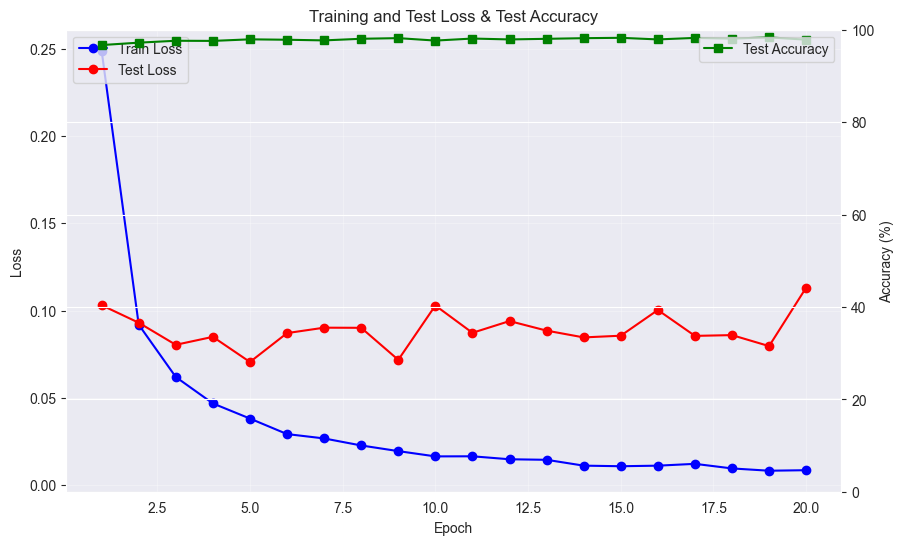

In [26]:
model, metrics = train_and_evaluate(MNISTNet(), train_gen, test_gen, device, num_epochs=20, learning_rate=1e-3)

plot_training_metrics(metrics)
